# Training a ResNet on the CIFAR10 dataset.

Deeper neural networks are more difficult to train. ResNet reformulates the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions.

According to the Universal Approximation theorem, given enough capacity, we know that a feedforward network with single layer is sufficient to represent any function. However, the layer might be massive and network is prone to overfitting the data. 
Therefore, there is a common trend in the research community that the network architecture needs to go deeper.

Since AlexNet, the state-of-the-art CNN architecture is going deeper and deeper. While AlexNet had 5 convolultional layers, the VGG network and GoogleNet had 19 and 22 layers respectively. 

Increasing network depth does not work by simpy stacking layers together. It makes the <b> vanishing gradient problem </b> more significant. As the gradient is back-propogated to earlier layers, repeated multiplication may make the gradient infinitively small. As a result, as the network goes deeper, its performance gets saturated or even degrades rapdily.
![image.png](https://github.com/smit585/ReinforcementLearning/blob/master/GitLab%20Images/download.png?raw=true)



## ResNet

Before ResNet, there had been several ways to deal the vanishing gradient issue. One may be to add an auxilairy loss in the middle layer as extra supervision, but it didn't seem to really tackle the problem once and for all.

The core idea of ResNet is introducing a so-called <b> "Indentity Shortcut connection" </b> that skips one or more layers as shown in the following figure: 
![image.png](https://github.com/smit585/ReinforcementLearning/blob/master/GitLab%20Images/download1.png?raw=true)

## Comparison with other Network Architecture
On the ImageNet dataset this method was evaluated with residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. This technique can also be applied to the CIFAR-10 with 100 and 1000 layers.
![image.png](https://github.com/smit585/ReinforcementLearning/blob/master/GitLab%20Images/download%20(1).png?raw=true)

## Implementing ResNet with Keras
What is a residual?

* [Residual](https://www.merriam-webster.com/dictionary/residual): an internal aftereffect of experience or activity that influences later behavior

To implement a ResNet we need to give Keras the notion of a residual block. This is essentially two dense layers with a "skip connection". Residual blocks are typically used with convolutional neural networks (CNNs). 

## CIFAR Dataset
The [CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) datasets are frequently used by the neural network research community.  These datasets were originally part of a competition. 

The CIFAR-10 data set contains low-res images that are divided into 10 classes.  The CIFAR-100 data set contains 100 classes in a hierarchy. 


In [1]:
# Clear the GPU memory
ToClearGPU = True
if ToClearGPU:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()

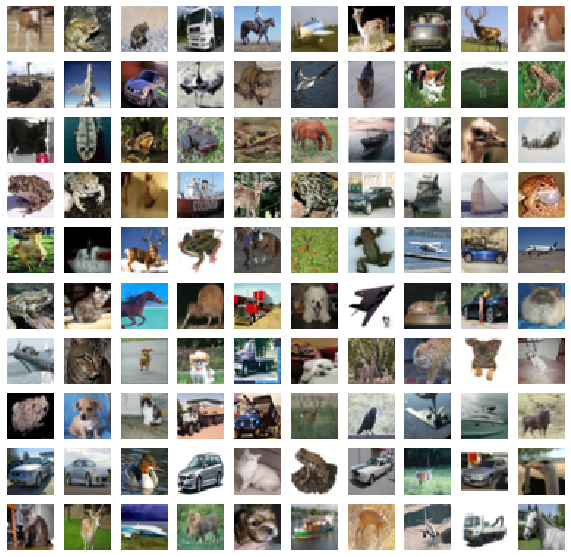

In [2]:
%matplotlib inline
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# How many rows of Images to display
ROWS = 10

# How many columns of Images to display
COLS = 10

x = x_train.astype("uint8")

# Create a subplot for 10 rows and 10 columns
fig, axes1 = plt.subplots(ROWS, COLS, figsize=(10, 10))

for j in range(ROWS):
    for k in range(COLS):
        # Randomly pick from the range of X
        i = np.random.choice(range(len(x)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x[i:i+1][0])

## Constructing ResNet and Training it on CIFAR-1o dataset

In [3]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

# Setting the Hyper parameters
# Training parameters
BATCH_SIZE = 32  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 200
USE_AUGMENTATION = True
NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = x_train.shape[3]

# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = True

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
VERSION = 1

# Computed depth from supplied model parameter n
if VERSION == 1:
    DEPTH = COLORS * 6 + 2
elif version == 2:
    DEPTH = COLORS * 9 + 2

The following function would decay the learning rate

In [4]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

The following code implements a ResNet block. This includes two convolutional layers with a skip connection.
Both V1 and V2 of ResNet make use of this type of layer

In [5]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

## ResNet V1

In [6]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

## ResNet V2

In [ ]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

With the Models defined, we can run the ResNet

In [7]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

# Create the neural network
if VERSION == 2:
    model = resnet_v2(input_shape=input_shape, depth=DEPTH)
else:
    model = resnet_v1(input_shape=input_shape, depth=DEPTH)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_n

# CallBacks
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.
We are using two CallBack functions
1. <b> ReduceLROnPlateau </b>
    Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. Arguments 
        monitor: Quantity to be monitored
        
        factor: factor by which the learning rate will be reduced. new_lr = lr * factor
        
        patience: number of epochs with no improvement after which learning rate will be reduced.
        
        verbose: int. 0: quiet, 1: update messages.
        
        mode: one of {auto, min, max}. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing; in auto mode, the direction is automatically inferred from the name of the monitored quantity.
        
        min_delta: threshold for measuring the new optimum, to only focus on significant changes.
        
        cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
        
        min_lr: lower bound on the learning rate.
        
2. <b> LearningRateScheduler </b>
    Learning rate scheduler. Arguments:
        schedule: a function that takes an epoch index as input (integer, indexed from 0) and current learning rate and returns a new learning rate as output (float).
        
        verbose: int. 0: quiet, 1: update messages.

The approach that implements variable learning rate is called as <b> Simulated Annealing </b>, or decaying learning rate. In this, learning rate is decayed every fixed number of iterations. This has an advantage over the fixed learning rate that as the gradient approaches zero in the loss function, we should take smalled and smaller steps to reach the minimum. If the learning rate (or step size to reach minimum) is too large, we may overshoot minima and bounce between the ridges of the minima.
![GradientDescentTrajectory](https://blog.paperspace.com/content/images/2018/05/68747470733a2f2f707669676965722e6769746875622e696f2f6d656469612f696d672f70617274312f6772616469656e745f64657363656e742e676966.gif)

In [8]:
import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        validation_data=(x_test, y_test),
                        epochs=EPOCHS, verbose=2, workers=1,
                        callbacks=callbacks, use_multiprocessing=False)
    
elapsed_time = time.time() - start_time
days = elapsed_time // 86400
hours = elapsed_time // 3600 % 24
minutes = elapsed_time // 60 % 60
seconds = elapsed_time % 60
print(f"ElapsedTime: {days}:{hours}:{minutes}:{seconds}")

Using real-time data augmentation.
Train for 1563 steps, validate on 10000 samples
Learning rate:  0.001
Epoch 1/200
1563/1563 - 110s - loss: 1.5929 - accuracy: 0.4805 - val_loss: 1.5759 - val_accuracy: 0.5075
Learning rate:  0.001
Epoch 2/200
1563/1563 - 85s - loss: 1.2070 - accuracy: 0.6268 - val_loss: 1.3130 - val_accuracy: 0.6040
Learning rate:  0.001
Epoch 3/200
1563/1563 - 88s - loss: 1.0395 - accuracy: 0.6905 - val_loss: 1.1085 - val_accuracy: 0.6709
Learning rate:  0.001
Epoch 4/200
1563/1563 - 93s - loss: 0.9387 - accuracy: 0.7318 - val_loss: 1.1330 - val_accuracy: 0.6685
Learning rate:  0.001
Epoch 5/200
1563/1563 - 100s - loss: 0.8703 - accuracy: 0.7568 - val_loss: 1.4105 - val_accuracy: 0.6234
Learning rate:  0.001
Epoch 6/200
1563/1563 - 99s - loss: 0.8259 - accuracy: 0.7738 - val_loss: 0.9818 - val_accuracy: 0.7241
Learning rate:  0.001
Epoch 7/200
1563/1563 - 88s - loss: 0.7846 - accuracy: 0.7897 - val_loss: 0.8847 - val_accuracy: 0.7595
Learning rate:  0.001
Epoch 8/200

Learning rate:  0.001
Epoch 65/200
1563/1563 - 46s - loss: 0.5002 - accuracy: 0.9002 - val_loss: 0.6604 - val_accuracy: 0.8555
Learning rate:  0.001
Epoch 66/200
1563/1563 - 46s - loss: 0.5021 - accuracy: 0.8997 - val_loss: 0.6632 - val_accuracy: 0.8523
Learning rate:  0.001
Epoch 67/200
1563/1563 - 46s - loss: 0.4987 - accuracy: 0.9012 - val_loss: 0.6986 - val_accuracy: 0.8544
Learning rate:  0.001
Epoch 68/200
1563/1563 - 46s - loss: 0.4972 - accuracy: 0.9012 - val_loss: 0.6789 - val_accuracy: 0.8518
Learning rate:  0.001
Epoch 69/200
1563/1563 - 46s - loss: 0.4970 - accuracy: 0.9018 - val_loss: 0.7071 - val_accuracy: 0.8394
Learning rate:  0.001
Epoch 70/200
1563/1563 - 46s - loss: 0.4960 - accuracy: 0.9013 - val_loss: 0.6524 - val_accuracy: 0.8581
Learning rate:  0.001
Epoch 71/200
1563/1563 - 46s - loss: 0.4995 - accuracy: 0.9007 - val_loss: 0.7534 - val_accuracy: 0.8255
Learning rate:  0.001
Epoch 72/200
1563/1563 - 46s - loss: 0.4910 - accuracy: 0.9035 - val_loss: 0.7911 - val_a

Learning rate:  1e-05
Epoch 129/200
1563/1563 - 46s - loss: 0.1668 - accuracy: 0.9887 - val_loss: 0.5017 - val_accuracy: 0.9115
Learning rate:  1e-05
Epoch 130/200
1563/1563 - 47s - loss: 0.1637 - accuracy: 0.9890 - val_loss: 0.5011 - val_accuracy: 0.9110
Learning rate:  1e-05
Epoch 131/200
1563/1563 - 46s - loss: 0.1633 - accuracy: 0.9892 - val_loss: 0.4975 - val_accuracy: 0.9113
Learning rate:  1e-05
Epoch 132/200
1563/1563 - 46s - loss: 0.1637 - accuracy: 0.9890 - val_loss: 0.4971 - val_accuracy: 0.9111
Learning rate:  1e-05
Epoch 133/200
1563/1563 - 46s - loss: 0.1630 - accuracy: 0.9893 - val_loss: 0.5010 - val_accuracy: 0.9102
Learning rate:  1e-05
Epoch 134/200
1563/1563 - 46s - loss: 0.1626 - accuracy: 0.9895 - val_loss: 0.5024 - val_accuracy: 0.9097
Learning rate:  1e-05
Epoch 135/200
1563/1563 - 46s - loss: 0.1621 - accuracy: 0.9894 - val_loss: 0.4997 - val_accuracy: 0.9106
Learning rate:  1e-05
Epoch 136/200
1563/1563 - 46s - loss: 0.1604 - accuracy: 0.9904 - val_loss: 0.4986

1563/1563 - 45s - loss: 0.1489 - accuracy: 0.9927 - val_loss: 0.5085 - val_accuracy: 0.9107
Learning rate:  5e-07
Epoch 194/200
1563/1563 - 47s - loss: 0.1491 - accuracy: 0.9922 - val_loss: 0.5098 - val_accuracy: 0.9102
Learning rate:  5e-07
Epoch 195/200
1563/1563 - 47s - loss: 0.1491 - accuracy: 0.9925 - val_loss: 0.5105 - val_accuracy: 0.9108
Learning rate:  5e-07
Epoch 196/200
1563/1563 - 48s - loss: 0.1490 - accuracy: 0.9928 - val_loss: 0.5128 - val_accuracy: 0.9101
Learning rate:  5e-07
Epoch 197/200
1563/1563 - 47s - loss: 0.1492 - accuracy: 0.9925 - val_loss: 0.5117 - val_accuracy: 0.9091
Learning rate:  5e-07
Epoch 198/200
1563/1563 - 47s - loss: 0.1498 - accuracy: 0.9926 - val_loss: 0.5106 - val_accuracy: 0.9088
Learning rate:  5e-07
Epoch 199/200
1563/1563 - 46s - loss: 0.1484 - accuracy: 0.9928 - val_loss: 0.5123 - val_accuracy: 0.9102
Learning rate:  5e-07
Epoch 200/200
1563/1563 - 47s - loss: 0.1507 - accuracy: 0.9918 - val_loss: 0.5118 - val_accuracy: 0.9097
ElapsedTime:

The trained neural network can now be evaluated.

In [9]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/1 [======] - 2s 198us/sample - loss: 0.6650 - accuracy: 0.9097
Test loss: 0.511777879667282
Test accuracy: 0.9097


In sum, the network took 2 hours to fit all the data, and its overall accuracy on test data set was approximately 91%.